In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#음수를 하이픈으로 처리하는 코드
plt.rcParams['axes.unicode_minus'] = False 
#한글 폰트 적용
plt.rcParams['font.family'] = 'NanumGothicCoding'

In [3]:
#전처리 한 데이터 불러오기
df = pd.read_csv('./train_ms_.csv')
y = df.pop("withdrawal")

In [4]:
#train, test 나누기 20% 비율
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# 기본 랜덤 포레스트 모델 돌리기
rf_basic = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42)
rf_basic.fit(X_train, y_train)
y_pred_basic = rf_basic.predict(X_test)
y_prob_basic = rf_basic.predict_proba(X_test)[:, 1]

정확도: 0.6919431279620853
정밀도: 0.6919431279620853
재현율: 1.0
F1-score: 0.8179271708683473
ROC-AUC: 0.6257112750263436
[[  0  65]
 [  0 146]]


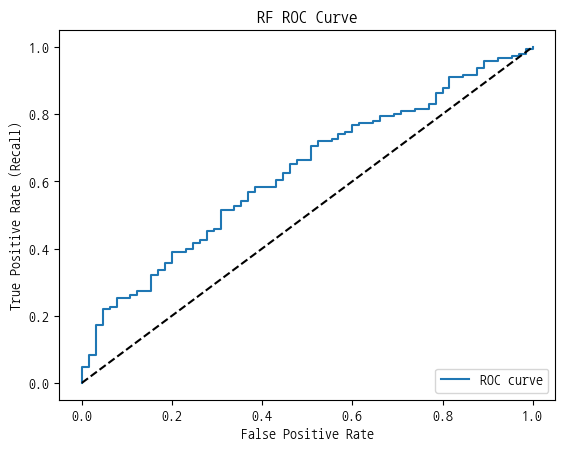

In [6]:
#평가 지표 출력
print('정확도:', accuracy_score(y_test, y_pred_basic))
print('정밀도:', precision_score(y_test, y_pred_basic))
print('재현율:', recall_score(y_test, y_pred_basic))
print('F1-score:', f1_score(y_test, y_pred_basic))
print('ROC-AUC:', roc_auc_score(y_test, y_prob_basic))
print(confusion_matrix(y_test,y_pred_basic))

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_prob_basic)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('RF ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [7]:
# 하이퍼파라미터 그리드 후 랜덤 포레스트
param_grid = {
    'n_estimators': [50,100,150],
    'max_depth': np.arange(3,10),
    'min_samples_split': np.arange(2,5)
}
rf_grid = RandomForestClassifier(random_state=42)
halving_search = HalvingGridSearchCV(rf_grid, param_grid, cv=5, scoring='f1')
halving_search.fit(X_train, y_train)
best_rf_grid = halving_search.best_estimator_
y_pred_grid = best_rf_grid.predict(X_test)
y_prob_grid = best_rf_grid.predict_proba(X_test)[:, 1]

정확도: 0.6919431279620853
정밀도: 0.6919431279620853
재현율: 1.0
F1-score: 0.8179271708683473
ROC-AUC: 0.6257112750263436
[[  0  65]
 [  0 146]]


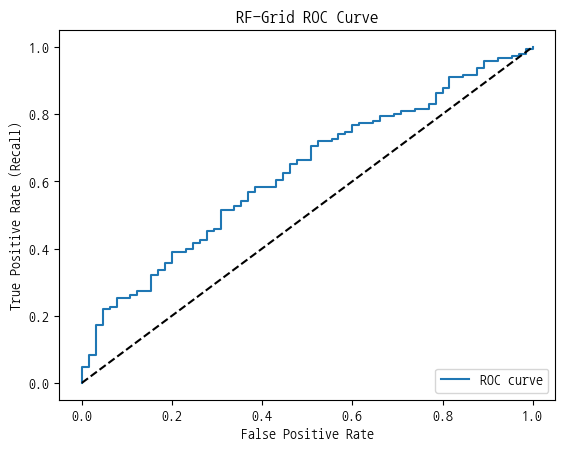

In [8]:
print('정확도:', accuracy_score(y_test, y_pred_grid))
print('정밀도:', precision_score(y_test, y_pred_grid))
print('재현율:', recall_score(y_test, y_pred_grid))
print('F1-score:', f1_score(y_test, y_pred_grid))
print('ROC-AUC:', roc_auc_score(y_test, y_prob_grid))
print(confusion_matrix(y_test,y_pred_grid))

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_prob_grid)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('RF-Grid ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [9]:
##데이터 증강

# 1. 데이터 다시 불러오기
df2 = pd.read_csv('./train_ms_.csv')

# 2. 모든 object 컬럼을 category로 변환
df2[df2.select_dtypes(include='object').columns] = df2.select_dtypes(include='object').astype('category')

# 3. 메타데이터 자동 생성
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df2)

# 4. CTGAN 모델 학습
synthesizer = CTGANSynthesizer(
    metadata,
    epochs=500,
    batch_size=500,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256)
)
synthesizer.fit(df2)

# 5. 데이터 증강
synthetic_data = synthesizer.sample(num_rows=len(df2)*3)

# 6. 원본과 결합
combined_df = pd.concat([df2, synthetic_data], ignore_index=True)
combined_df.to_csv("./combined_test.csv", encoding="utf-8-sig", index=False)
y_combined = combined_df.pop("withdrawal")

# 7. 확인
print("Combined shape:", combined_df.shape)
print("y shape:", y_combined.shape)

/home/calix28/miniconda3/envs/pandas/lib/python3.12/site-packages/sdv/single_table/base.py:163: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/calix28/miniconda3/envs/pandas/lib/python3.12/site-packages/sdv/single_table/base.py:129: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Combined shape: (4208, 84)
y shape: (4208,)


In [10]:
#오버샘플링 SMOTE사용
from imblearn.over_sampling import SMOTE
combined_df1 = pd.read_csv("./combined_df.csv")
y1 = combined_df1.pop("withdrawal")
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(combined_df1,y1)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [11]:
# 랜덤포레스트 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [50,100,150],
    'max_depth': np.arange(3,10),
    'min_samples_split': np.arange(2,5)
}
rf_smote = RandomForestClassifier(random_state=42)
halving_search = HalvingGridSearchCV(rf_smote, param_grid, cv=5, scoring='f1')
halving_search.fit(X_train_smote, y_train_smote)

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                'min_samples_split': array([2, 3, 4]),
                                'n_estimators': [50, 100, 150]},
                    scoring='f1')

In [12]:
rf_smote_best = halving_search.best_estimator_
y_pred_smote = rf_smote_best.predict(X_test_smote)
y_prob_smote = rf_smote_best.predict_proba(X_test_smote)[:, 1]

정확도: 0.7539184952978056
정밀도: 0.7673267326732673
재현율: 0.7288401253918495
F1-score: 0.747588424437299
ROC-AUC: 0.8322171558848674
[[497 141]
 [173 465]]


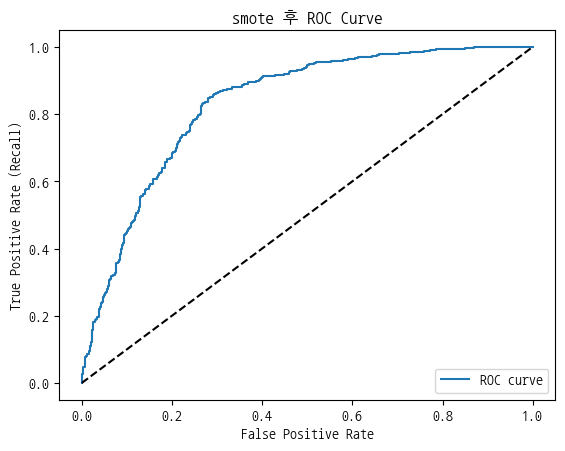

In [13]:
print('정확도:', accuracy_score(y_test_smote, y_pred_smote))
print('정밀도:', precision_score(y_test_smote, y_pred_smote))
print('재현율:', recall_score(y_test_smote, y_pred_smote))
print('F1-score:', f1_score(y_test_smote, y_pred_smote))
print('ROC-AUC:', roc_auc_score(y_test_smote, y_prob_smote))
print(confusion_matrix(y_test_smote,y_pred_smote))

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test_smote, y_prob_smote)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('smote 후 ROC Curve')
plt.legend(loc='lower right')
plt.show()

정확도: 0.8440438871473355
정밀도: 0.837173579109063
재현율: 0.85423197492163
F1-score: 0.8456167571761055
ROC-AUC: 0.918689380017885
[[532 106]
 [ 93 545]]


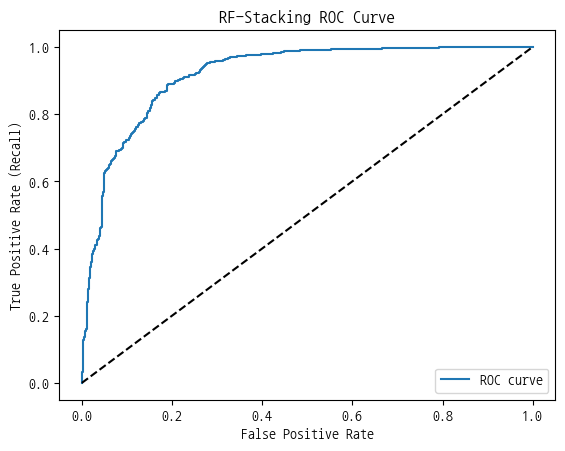

In [14]:
#stacking - 랜덤포레스트 + K-이웃분류 + XGBoost + 로지스틱 회귀
base_models = [
    ('rf', rf_smote_best),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier( eval_metric='logloss'))
]
meta_model = LogisticRegression()

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking.fit(X_train_smote, y_train_smote)

y_pred_stacking = stacking.predict(X_test_smote)
y_prob_stacking = stacking.predict_proba(X_test_smote)[:, 1]
f1_score, roc_auc_score
print("정확도:", accuracy_score(y_test_smote, y_pred_stacking))
print("정밀도:", precision_score(y_test_smote, y_pred_stacking))
print("재현율:", recall_score(y_test_smote, y_pred_stacking))
print("F1-score:", f1_score(y_test_smote, y_pred_stacking))
print("ROC-AUC:", roc_auc_score(y_test_smote, y_prob_stacking))
print(confusion_matrix(y_test_smote,y_pred_stacking))

#ROC 곡선
fpr, tpr, thresholds = roc_curve(y_test_smote, y_prob_stacking)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('RF-Stacking ROC Curve')
plt.legend(loc='lower right')
plt.show()

보팅 - 정확도: 0.8087774294670846
보팅 - 정밀도: 0.8305369127516778
보팅 - 재현율: 0.7758620689655172
보팅 - F1-score: 0.8022690437601296
보팅 - ROC-AUC: 0.894424190013856
[[537 101]
 [143 495]]


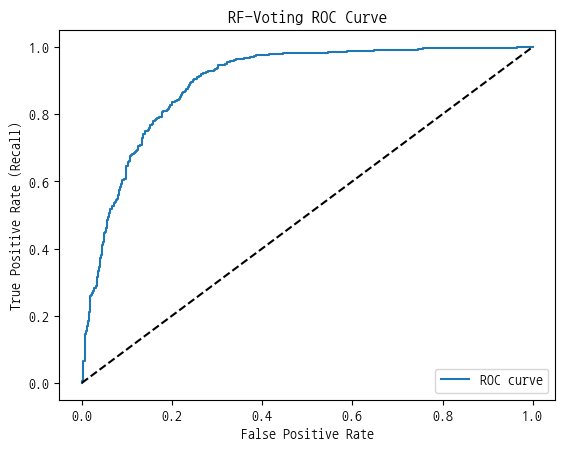

In [15]:
#Voting - 랜덤포레스트 + 로지스틱 회귀 + K-이웃 분류
voting = VotingClassifier(
    estimators=[
        ('rf', rf_smote_best),  # 앞서 튜닝한 랜덤포레스트
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    voting='soft'  # 예측 확률 평균 방식
)
voting.fit(X_train_smote, y_train_smote)

y_pred_voting = voting.predict(X_test_smote)
y_prob_voting = voting.predict_proba(X_test_smote)[:, 1]

print("보팅 - 정확도:", accuracy_score(y_test_smote, y_pred_voting))
print("보팅 - 정밀도:", precision_score(y_test_smote, y_pred_voting))
print("보팅 - 재현율:", recall_score(y_test_smote, y_pred_voting))
print("보팅 - F1-score:", f1_score(y_test_smote, y_pred_voting))
print("보팅 - ROC-AUC:", roc_auc_score(y_test_smote, y_prob_voting))
print(confusion_matrix(y_test_smote,y_pred_voting))

#ROC 곡선
fpr, tpr, thresholds = roc_curve(y_test_smote, y_prob_voting)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('RF-Voting ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
# XGBoost용 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200],           # 3개 -> 2개
    'max_depth': [3, 5, 7],               # 5개 -> 3개
    'learning_rate': [0.05, 0.1],         # 4개 -> 2개
    'subsample': [0.8, 1.0],              # 3개 -> 2개
    'colsample_bytree': [0.8, 1.0],       # 3개 -> 2개
    'min_child_weight': [1, 3],           # 3개 -> 2개
    'gamma': [0, 0.1]                     # 4개 -> 2개
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

halving_search = HalvingGridSearchCV(
    xgb,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,  # 학습 과정 로그 출력
    n_jobs=-1   # 병렬 처리
)

halving_search.fit(X_train_smote, y_train_smote)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 63
max_resources_: 5104
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 63
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 1
n_candidates: 64
n_resources: 189
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 2
n_candidates: 22
n_resources: 567
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 3
n_candidates: 8
n_resources: 1701
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 5103
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...),
                    n_jobs=-1,
                    param_grid={'colsample_bytree': [0.8, 1.0],
                                'gamma': [0, 0.1], 'learning_rate': [0.05, 0.1],
                                'max_depth': [3, 5, 7],
                                'min_child_weight': [1, 3],
                                'n_estimators': [100, 200],
                                'subsample': [0.8, 1.0]},
                    scoring='f1', verbose=1)

In [17]:
best_xgb = halving_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_smote)
y_prob_xgb = best_xgb.predict_proba(X_test_smote)[:, 1]

정확도: 0.7938871473354232
정밀도: 0.7871362940275651
재현율: 0.8056426332288401
F1-score: 0.796281951975213
ROC-AUC: 0.8676433014612671
[[499 139]
 [124 514]]


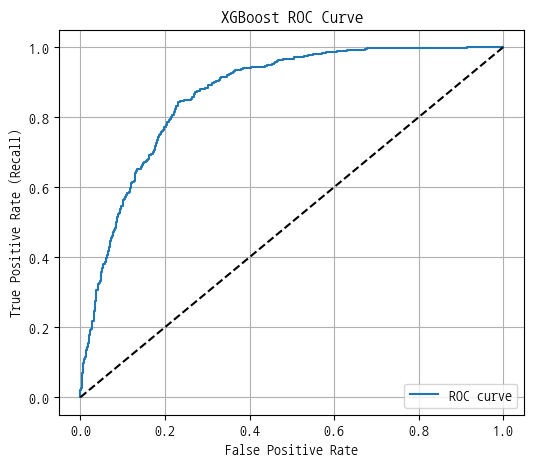

In [18]:
#평가 지표 출력
print('정확도:', accuracy_score(y_test_smote, y_pred_xgb))
print('정밀도:', precision_score(y_test_smote, y_pred_xgb))
print('재현율:', recall_score(y_test_smote, y_pred_xgb))
print('F1-score:', f1_score(y_test_smote, y_pred_xgb))
print('ROC-AUC:', roc_auc_score(y_test_smote, y_prob_xgb))
print(confusion_matrix(y_test_smote,y_pred_xgb))

#ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_smote, y_prob_xgb)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
best_model = stacking

import pickle

with open('best_model(stacking).pkl', 'wb') as f:
    pickle.dump(best_model, f)

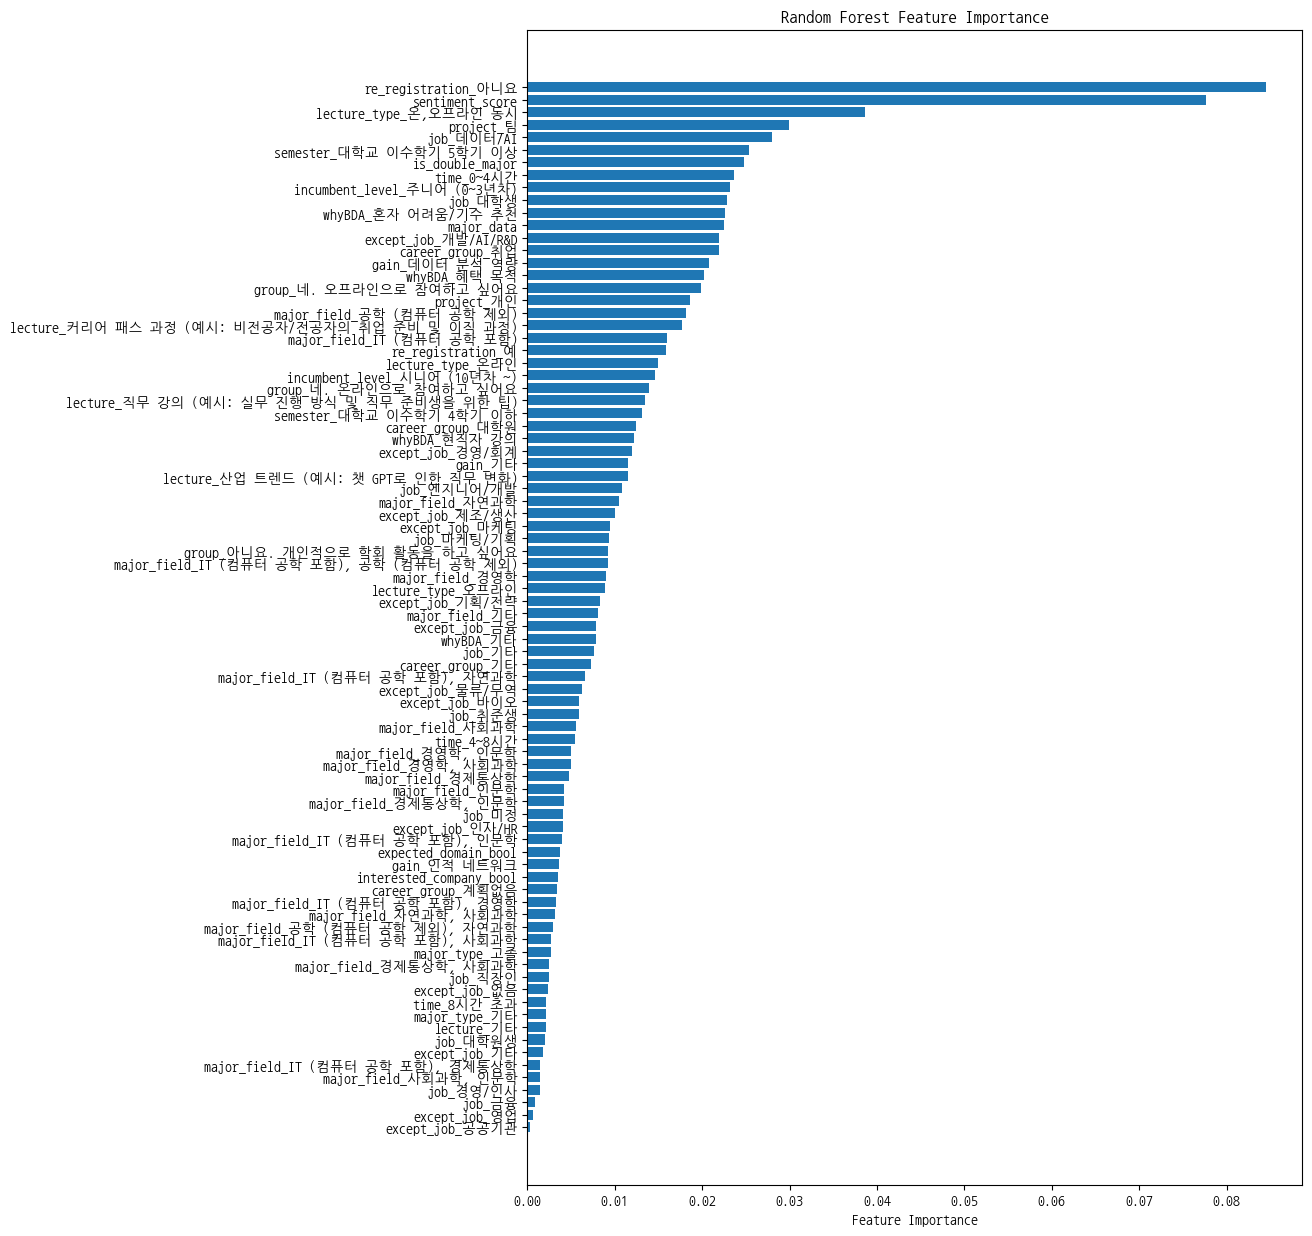

In [20]:
importances = rf_smote_best.feature_importances_

# 특성 이름 (X가 DataFrame일 경우)
feature_names = X_train_smote.columns if hasattr(df, 'columns') else [f'Feature {i}' for i in range(X_train_smote.shape[1])]

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 그래프 그리기
plt.figure(figsize=(10,15))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()  # 중요도 높은 특성이 위로
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [21]:
# AdaBoost용 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [50, 100, 200],        # 부스팅 반복 수
    'learning_rate': [0.01, 0.1, 1.0],     # 학습률
}

ada = AdaBoostClassifier(random_state=42)

halving_search = HalvingGridSearchCV(
    ada,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

halving_search.fit(X_train_smote, y_train_smote)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 567
max_resources_: 5104
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 567
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 1701
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 5103
Fitting 5 folds for each of 1 candidates, totalling 5 fits


HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
                    param_grid={'learning_rate': [0.01, 0.1, 1.0],
                                'n_estimators': [50, 100, 200]},
                    scoring='f1', verbose=1)

In [22]:
best_ada = halving_search.best_estimator_
y_pred_ada = best_ada.predict(X_test_smote)
y_prob_ada = best_ada.predict_proba(X_test_smote)[:, 1]

정확도: 0.707680250783699
정밀도: 0.7140549273021002
재현율: 0.6927899686520376
F1-score: 0.7032617342879872
ROC-AUC: 0.7786578355165534
[[461 177]
 [196 442]]


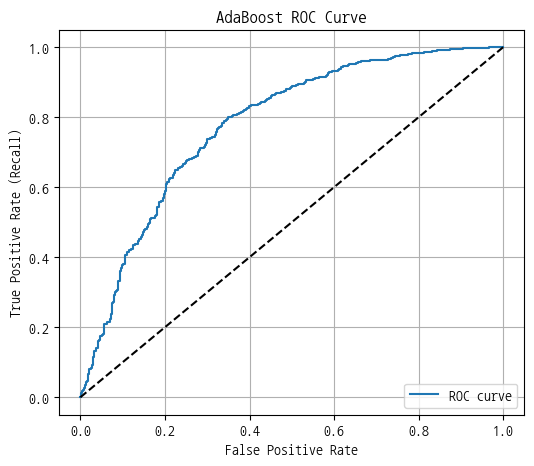

In [23]:
#평가 지표 출력
print('정확도:', accuracy_score(y_test_smote, y_pred_ada))
print('정밀도:', precision_score(y_test_smote, y_pred_ada))
print('재현율:', recall_score(y_test_smote, y_pred_ada))
print('F1-score:', f1_score(y_test_smote, y_pred_ada))
print('ROC-AUC:', roc_auc_score(y_test_smote, y_prob_ada))
print(confusion_matrix(y_test_smote,y_pred_ada))

#ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_smote, y_prob_ada)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('AdaBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()